### Target is to perform basic probit regression, both directly and through Data Augmentation, and compare the results on the same dataset

$$ Y_i \sim \mbox{Bernoulli} \left( \Phi \left( x_i^T \beta \right) \right), i = 1 \dots n, \; \beta \sim \mathcal{N} \left( 0, I_p \right) $$
$$ \Big \Updownarrow $$
$$ Y_i = \mathbb{1}_{z_i > 0}, \; z_i \sim \mathcal{N} \left( x_i^T \beta, 1 \right), i = 1 \dots n, \; \beta \sim \mathcal{N} \left( 0, I_p \right) $$

$\beta$ : Main Parameter of Interest, $z_i$ : latent variable

In [1]:
%load_ext cmdstanjupyter

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy import linalg
from scipy import special
import matplotlib.pyplot as plt
import arviz as ar
import seaborn as sns

In [3]:
# choose n even
n = 100
p = 5
X1 = np.random.uniform(size = (n//2, p))
X2 = -np.random.uniform(size = (n//2, p))
X = np.append(X1, X2, axis = 0)
Y = np.array([1]*(n//2) + [0]*(n//2))

In [4]:
%%stan beta_model
data{
    int<lower = 1> n;
    int<lower = 1> p;
    matrix[n, p] X;
    array[n] int<lower=0, upper=1> Y;
}

parameters{
    vector[p] beta;
}

model{
    beta ~ normal(0, 1);
    for(i in 1:n){
        Y[i] ~ bernoulli(normal_cdf(X[i,]*beta| 0, 1));
    }
}

INFO:cmdstanjupyter:Reusing cached model file .stan/beta_model.stan
INFO:cmdstanjupyter:Creating CmdStanPy model & assigning it to variable "beta_model"
INFO:cmdstanjupyter:StanModel now available as variable "beta_model"!
 Compilation took a moment.


In [5]:
beta_data = {'n':n, 'p':p, 'X':X, 'Y':Y}
beta_fit = beta_model.sample(data = beta_data)

14:05:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:05:34 - cmdstanpy - INFO - CmdStan done processing.


In [84]:
beta_fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-7.18950,0.036906,1.636270,-10.346000,-6.85836,-5.21732,1965.69,1999.69,0.999579
beta[1],1.19005,0.012607,0.786666,-0.089815,1.17955,2.52589,3893.60,3960.94,1.000050
beta[2],1.15922,0.013085,0.783810,-0.096459,1.14042,2.51040,3588.02,3650.07,1.000100
beta[3],1.26987,0.012502,0.796256,0.013595,1.25873,2.65163,4056.78,4126.93,0.999441
beta[4],1.28067,0.012651,0.757139,0.056252,1.27723,2.53681,3581.77,3643.71,0.999767
beta[5],1.26247,0.013045,0.804239,-0.039973,1.24851,2.60718,3801.01,3866.74,1.000750


In [89]:
beta_fit.stan_variable(var = 'beta').T

array([[ 0.532125 ,  1.14499  , -0.224128 , ...,  1.35927  ,  1.10978  ,
         0.68379  ],
       [ 1.05282  ,  1.52028  ,  1.42919  , ...,  0.244855 ,  1.56349  ,
         1.12847  ],
       [ 1.0839   ,  1.33287  ,  0.0860159, ...,  1.16107  ,  0.901567 ,
         0.784005 ],
       [ 2.00344  ,  1.97957  ,  1.29042  , ...,  0.609959 ,  0.539473 ,
         0.324466 ],
       [ 0.993084 ,  1.47773  ,  1.82399  , ...,  2.02261  ,  2.12706  ,
         1.49596  ]])

In [93]:
draws = beta_fit.stan_variable(var = 'beta').T

<AxesSubplot:ylabel='Count'>

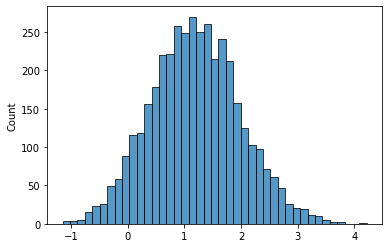

In [94]:
sns.histplot(draws[0])

<AxesSubplot:ylabel='Count'>

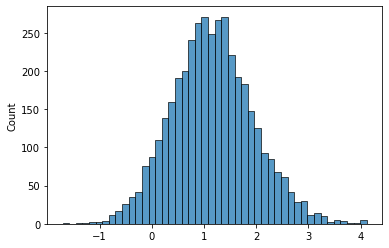

In [95]:
sns.histplot(draws[1])

<AxesSubplot:ylabel='Count'>

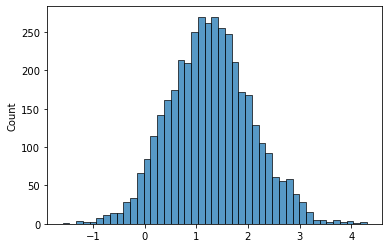

In [96]:
sns.histplot(draws[2])

<AxesSubplot:ylabel='Count'>

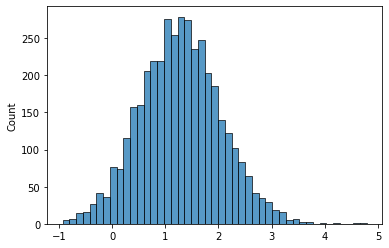

In [97]:
sns.histplot(draws[3])

<AxesSubplot:ylabel='Count'>

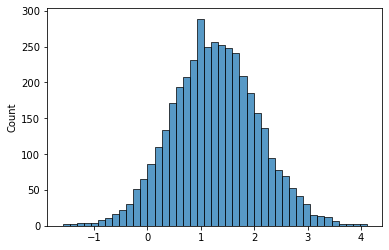

In [98]:
sns.histplot(draws[4])

### Data Augmentation Iterations

In [179]:
# takes around 15 mins
K = 50
J = 50
n_iter = 1000
no_draws = 1000
cov = linalg.inv(np.identity(p) + np.matmul(X.T, X))
beta_mat = np.random.normal(size = (K, p))
beta_draws = np.zeros((no_draws, p))
z_mat = np.zeros((J, n))
for l in range(n_iter):
    for j in range(J):
        k = np.argmax(np.random.multinomial(n = 1, pvals = np.ones(K)/K))
        beta = beta_mat[k]
        for i in range(n):
            if Y[i] == 1:
                z_mat[j, i] = trunc_draw_plus(n_samples = 1, mu = np.dot(X[i], beta))[0]
            else:
                z_mat[j, i] = trunc_draw_minus(n_samples = 1, mu = np.dot(X[i], beta))[0]
    for k in range(K):
        j = np.argmax(np.random.multinomial(n = 1, pvals = np.ones(J)/J))
        z_vec = z_mat[j]
        mu = np.matmul(cov, np.matmul(X.T, z_vec))
        beta_mat[k] = np.random.multivariate_normal(mean = mu, cov = cov)
for l in range(no_draws):
        j = np.argmax(np.random.multinomial(n = 1, pvals = np.ones(J)/J))
        z_vec = z_mat[j]
        mu = np.matmul(cov, np.matmul(X.T, z_vec))
        beta_draws[l] = np.random.multivariate_normal(mean = mu, cov = cov)
beta_draws = beta_draws.T

<AxesSubplot:ylabel='Count'>

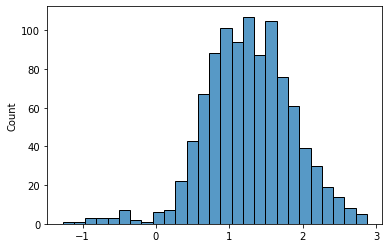

In [180]:
sns.histplot(beta_draws[0])

<AxesSubplot:ylabel='Count'>

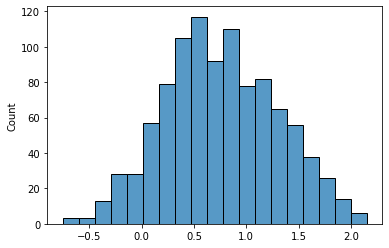

In [181]:
sns.histplot(beta_draws[1])

<AxesSubplot:ylabel='Count'>

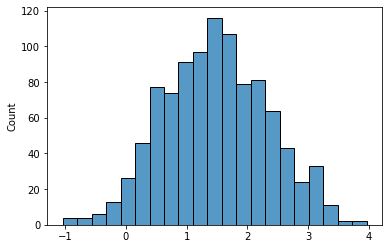

In [182]:
sns.histplot(beta_draws[2])

<AxesSubplot:ylabel='Count'>

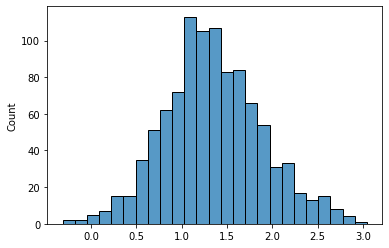

In [183]:
sns.histplot(beta_draws[3])

<AxesSubplot:ylabel='Count'>

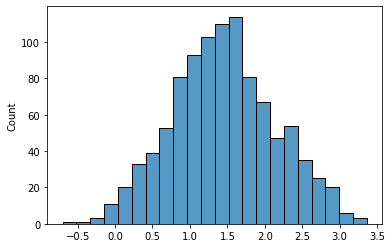

In [184]:
sns.histplot(beta_draws[4])

In [131]:
# red-flag with built in function !!!
stats.truncnorm.rvs(a = 0, b = np.inf, loc = -2, scale = 1)

-0.5896462512944076

In [161]:
# this function draws from N(\mu, 1) truncated on (0, \infty)
def trunc_draw_plus(n_samples, mu):
    U = np.random.uniform(size = n_samples)
    return np.array([mu - stats.norm.ppf((1 - u)*stats.norm.cdf(mu)) for u in U])

# this function draws from N(\mu, 1) truncated on (-\infty, 0)
def trunc_draw_minus(n_samples, mu):
    U = np.random.uniform(size = n_samples)
    return np.array([mu + stats.norm.ppf(u*stats.norm.cdf(-mu)) for u in U])

In [172]:
beta_mat

array([[-1.11026892,  0.90788568,  2.68967518,  2.51455658,  0.90743267],
       [-0.04983602,  0.93764703,  2.12625352,  2.8901835 ,  0.46035662],
       [ 0.54264296,  0.76840951,  1.3516185 ,  2.47451743,  0.74152523],
       [-0.29435022,  0.57209599,  1.81399641,  3.2156438 ,  0.94043932],
       [ 0.29960984,  0.58301939,  1.23294459,  3.14067369,  0.74991692],
       [ 0.33526747,  1.11565833,  1.57969271,  1.86336149,  1.29838334],
       [ 0.31064485,  1.25106987,  0.62953667,  1.49431617,  3.21725477],
       [-0.05537494,  0.85244803,  1.38428448,  3.11101236,  0.56846815],
       [ 0.44461852,  0.89271841,  1.29139667,  2.81729656,  0.50803906],
       [ 0.43732548,  1.95218536,  1.00737733,  0.88275726,  2.71549123]])